In [55]:
import numpy as np
import datajoint as dj
import time
import pymeshfix
import os
import datetime
import calcification_Module as cm
from meshparty import trimesh_io

#for supressing the output
import os, contextlib
import pathlib
import subprocess

#for error counting
from collections import Counter

#for reading in the new raw_skeleton files
import csv
import pandas as pd
from tqdm import tqdm


from meshparty import trimesh_io

#for filtering
import math
from pykdtree.kdtree import KDTree

import seaborn as sns

In [56]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20

schema = dj.schema('microns_ta3p100')
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')


In [57]:
#lose 10 dendrite segments to not having matching skeleton
len(ta3p100.DendriteWidth()),len(ta3p100.DendriteWidth() & "min_width_max>0")

(1838, 1828)

In [58]:
ta3p100.DendriteWidth & "min_width_max<0"

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,discrete_length the maximum size of a discretized segment of postsyn skeleton,min_width_perc_50 50th pecentile min width range for all skeleton,min_width_perc_55 55th pecentile min width range for all skeleton,min_width_perc_60 60th pecentile min width range for all skeleton,min_width_perc_65 65th pecentile min width range for all skeleton,min_width_perc_70 70th pecentile min width range for all skeleton,min_width_perc_75 75th pecentile min width range for all skeleton,min_width_perc_80 80th pecentile min width range for all skeleton,min_width_perc_85 85th pecentile min width range for all skeleton,min_width_perc_90 90th pecentile min width range for all skeleton,min_width_perc_95 95th pecentile min width range for all skeleton,min_width_max max min width range for all skeleton
2,648518346341403146,0.35,Dendrite,1,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346342797258,0.35,Dendrite,1,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349475531,0.35,Basal,9,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349493856,0.35,Basal,10,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349493856,0.35,Basal,13,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349493856,0.35,Oblique,1,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349499005,0.35,Basal,10,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349499669,0.35,Basal,5,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349505858,0.35,Basal,0,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,648518346349506684,0.35,Basal,5,10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [59]:
dendrite_accepted = ta3p100.DendriteWidth() & "min_width_max>0"

In [60]:
#get the distribution of all the 95 %
#pull down the 95 percentile
width_95_all = dendrite_accepted.fetch("min_width_perc_95")
#sns.set()
width_95_all



array([  258.371,   300.18 ,   335.249, ..., 24951.4  ,  9253.84 ,
       29925.4  ])

In [61]:
dendrite_accepted & "min_width_perc_95>10000"

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,discrete_length the maximum size of a discretized segment of postsyn skeleton,min_width_perc_50 50th pecentile min width range for all skeleton,min_width_perc_55 55th pecentile min width range for all skeleton,min_width_perc_60 60th pecentile min width range for all skeleton,min_width_perc_65 65th pecentile min width range for all skeleton,min_width_perc_70 70th pecentile min width range for all skeleton,min_width_perc_75 75th pecentile min width range for all skeleton,min_width_perc_80 80th pecentile min width range for all skeleton,min_width_perc_85 85th pecentile min width range for all skeleton,min_width_perc_90 90th pecentile min width range for all skeleton,min_width_perc_95 95th pecentile min width range for all skeleton,min_width_max max min width range for all skeleton
2,648518346341366885,0.35,Apical,0,10,309.835,436.078,3979.95,9550.53,13099.2,17606.2,21781.5,26915.4,33499.5,40410.6,64549.7
2,648518346341366885,0.35,Basal,0,10,194.936,215.555,243.038,299.06,5708.88,7731.29,10316.4,12527.5,13083.9,13880.9,22740.1
2,648518346341366885,0.35,Oblique,0,10,133.49,144.734,158.506,172.909,187.344,203.214,220.326,254.663,381.247,18572.0,27252.2
2,648518346341371119,0.35,Apical,0,10,162.972,177.352,191.778,208.593,231.578,276.652,397.793,3671.39,7533.02,14928.7,31486.4
2,648518346341371119,0.35,Basal,2,10,1372.8,2975.42,4435.61,5963.88,6925.81,9706.56,12118.2,12373.4,13358.8,14521.1,16858.5
2,648518346341371119,0.35,Basal,3,10,409.083,2237.18,3422.54,4641.33,6338.78,7644.26,9816.46,13420.4,17483.9,22897.7,30682.7
2,648518346341375427,0.35,Apical,0,10,238.023,278.832,344.855,471.007,771.145,7567.86,12600.8,16670.1,29367.0,34932.2,55657.4
2,648518346341375427,0.35,Basal,0,10,171.7,186.736,204.269,226.796,254.796,301.018,17431.9,22343.9,22869.1,24706.9,27962.5
2,648518346341375427,0.35,Basal,1,10,171.276,185.706,201.059,217.983,240.926,280.529,385.614,7115.43,14339.4,20183.0,25545.0
2,648518346341375427,0.35,Oblique,1,10,7215.8,10433.5,12792.2,17568.6,19126.6,21449.9,22079.7,22358.3,22898.0,23541.7,31038.8


In [62]:
#BECAUSE THE COMPONENT INDEX ISN'T ALWAYS THE LARGEST 
#get the list of the largest dendrite components and filter away the smaller ones
"""
Iterate over all dendrites in orphan
1) pull down the segment_ids
2) make unique segments ids (turn into set)
3) For each unique segment id pull down all component index and n_vertex_indices Compartment Rows from the start table:
a. Get the index of the highest vertex count
b. Save the segment_id, component_index and n_vertex_indices as a dict
c. Add it to the list of dicts

Use the list of dicts to restrict the width table

"""

start_table = (ta3p100.CompartmentOrphan.ComponentOrphan() & "compartment_type='Dendrite'").proj("n_vertex_indices")


In [65]:
start_table = (ta3p100.CompartmentOrphan.ComponentOrphan() & "compartment_type='Dendrite'").proj("n_vertex_indices")
seg_ids = start_table.fetch("segment_id")
len(seg_ids),len(set(seg_ids))

component_total = []
for s in set(seg_ids):
    print(s)
    seg_data = (start_table & "segment_id="+str(s)).fetch("component_index","n_vertex_indices")
    print(seg_data)
    components = seg_data[0]
    n_vertices = seg_data[1]
    print(components)
    print(n_vertices)
    
    #get the maximum n_vertices 
    n_verts_max = max(n_vertices)
    components_max = components[n_vertices == n_verts_max][0]
    
    print(n_verts_max)
    print(components_max)
    
    new_dict = dict(segment_id=s,component_index=components_max,n_vertex_indices=n_verts_max)
    component_total.append(new_dict)



648518346349506571
[array([0]), array([29699])]
[0]
[29699]
29699
0
648518346341355539
[array([0]), array([71989])]
[0]
[71989]
71989
0
648518346341402643
[array([0]), array([46897])]
[0]
[46897]
46897
0
648518346342803480
[array([0]), array([82627])]
[0]
[82627]
82627
0
648518346348103705
[array([0]), array([7854])]
[0]
[7854]
7854
0
648518346348120088
[array([0]), array([13074])]
[0]
[13074]
13074
0
648518346341406750
[array([0]), array([9679])]
[0]
[9679]
9679
0
648518346349105184
[array([0]), array([9139])]
[0]
[9139]
9139
0
648518346341392422
[array([0]), array([29983])]
[0]
[29983]
29983
0
648518346348464169
[array([0]), array([5858])]
[0]
[5858]
5858
0
648518346341400619
[array([0]), array([8047])]
[0]
[8047]
8047
0
648518346345670701
[array([0]), array([3736])]
[0]
[3736]
3736
0
648518346341396532
[array([0]), array([30769])]
[0]
[30769]
30769
0
648518346349467701
[array([0]), array([6848])]
[0]
[6848]
6848
0
648518346341396536
[array([0]), array([14421])]
[0]
[14421]
14421
0
6

In [66]:
len(seg_ids),len(set(seg_ids))

(597, 555)

In [67]:
#restrict starter table by dicts to make sure worked
start_table & component_total & "component_index>0"

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,n_vertex_indices
2,648518346341373109,0.35,Dendrite,1,1568
2,648518346341383270,0.35,Dendrite,1,1397
2,648518346341401733,0.35,Dendrite,2,17595
2,648518346341404564,0.35,Dendrite,1,164500
2,648518346342771094,0.35,Dendrite,2,2432
2,648518346342792507,0.35,Dendrite,1,39
2,648518346349475163,0.35,Dendrite,1,6


In [68]:
id = 648518346341373109
ta3p100.CompartmentOrphan.ComponentOrphan() & "compartment_type='Dendrite'" & "segment_id="+str(id)

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,n_vertex_indices,n_triangle_indices,vertex_indices preserved indices of each vertex of this sub-compartment,triangle_indices preserved indices of each triangle of this sub-compartment
2,648518346341373109,0.35,Dendrite,0,6,4,=BLOB=,=BLOB=
2,648518346341373109,0.35,Dendrite,1,1568,3113,=BLOB=,=BLOB=


In [69]:
#only want to do orphan width
dendrite_accepted & component_total & "compartment_type='Dendrite'" & "min_width_perc_95>800"

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,discrete_length the maximum size of a discretized segment of postsyn skeleton,min_width_perc_50 50th pecentile min width range for all skeleton,min_width_perc_55 55th pecentile min width range for all skeleton,min_width_perc_60 60th pecentile min width range for all skeleton,min_width_perc_65 65th pecentile min width range for all skeleton,min_width_perc_70 70th pecentile min width range for all skeleton,min_width_perc_75 75th pecentile min width range for all skeleton,min_width_perc_80 80th pecentile min width range for all skeleton,min_width_perc_85 85th pecentile min width range for all skeleton,min_width_perc_90 90th pecentile min width range for all skeleton,min_width_perc_95 95th pecentile min width range for all skeleton,min_width_max max min width range for all skeleton
2,648518346341379951,0.35,Dendrite,0,10,311.751,412.152,494.775,555.937,602.95,654.024,698.276,745.32,802.072,875.717,1098.44
2,648518346342413345,0.35,Dendrite,0,10,356.004,406.258,459.13,503.953,549.775,597.718,652.891,721.81,782.153,817.477,934.769
2,648518346349502882,0.35,Dendrite,0,10,243.132,297.17,349.06,399.445,449.277,511.389,574.408,637.308,716.684,826.295,1137.45


# Beginning of Analysis

In [70]:
print(len(ta3p100.DendriteWidth() & "min_width_max>0"))
print(len(ta3p100.DendriteWidth() & "min_width_max>0" & ta3p100.CompartmentOrphan.ComponentOrphan.proj()))
print(len(ta3p100.DendriteWidth() & "min_width_max>0" & ta3p100.CompartmentOrphan.ComponentOrphan.proj() & "compartment_type='Dendrite'"))
print(len(ta3p100.DendriteWidth() & "min_width_max>0" & ta3p100.CompartmentOrphan.ComponentOrphan.proj() & "compartment_type='Dendrite'" & component_total))



1828
408
376
376


In [71]:
dendrite_accepted = (ta3p100.DendriteWidth() & "min_width_max>0" & ta3p100.CompartmentOrphan.ComponentOrphan.proj() & "compartment_type='Dendrite'" & component_total)
dendrite_accepted

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,discrete_length the maximum size of a discretized segment of postsyn skeleton,min_width_perc_50 50th pecentile min width range for all skeleton,min_width_perc_55 55th pecentile min width range for all skeleton,min_width_perc_60 60th pecentile min width range for all skeleton,min_width_perc_65 65th pecentile min width range for all skeleton,min_width_perc_70 70th pecentile min width range for all skeleton,min_width_perc_75 75th pecentile min width range for all skeleton,min_width_perc_80 80th pecentile min width range for all skeleton,min_width_perc_85 85th pecentile min width range for all skeleton,min_width_perc_90 90th pecentile min width range for all skeleton,min_width_perc_95 95th pecentile min width range for all skeleton,min_width_max max min width range for all skeleton
2,648518346341352006,0.35,Dendrite,0,10,154.28,165.032,174.7,183.078,192.008,200.328,209.937,222.317,238.136,258.371,392.802
2,648518346341352223,0.35,Dendrite,0,10,135.366,150.72,167.2,182.182,196.393,211.754,227.688,247.355,268.368,300.18,490.499
2,648518346341353186,0.35,Dendrite,0,10,121.822,138.001,156.575,180.387,203.804,226.119,249.051,275.291,301.409,335.249,518.176
2,648518346341353607,0.35,Dendrite,0,10,189.99,243.526,292.89,340.675,380.026,417.451,448.828,484.598,529.635,582.155,754.599
2,648518346341353883,0.35,Dendrite,0,10,152.856,193.789,237.459,285.116,322.35,356.415,385.279,417.694,452.41,494.533,658.416
2,648518346341355539,0.35,Dendrite,0,10,130.573,141.073,152.455,164.553,177.114,190.542,205.099,221.688,242.112,270.548,457.418
2,648518346341356260,0.35,Dendrite,0,10,163.273,170.947,178.336,185.04,192.754,201.823,210.287,221.143,234.004,254.333,341.739
2,648518346341357297,0.35,Dendrite,0,10,163.238,177.16,191.784,206.519,222.545,240.305,260.258,291.053,349.122,473.654,955.697
2,648518346341359123,0.35,Dendrite,0,10,119.714,130.394,142.894,155.464,169.27,182.949,196.65,213.831,235.503,263.893,393.167
2,648518346341359289,0.35,Dendrite,0,10,109.993,123.845,145.105,167.476,191.174,212.384,236.799,262.662,289.259,328.8,477.253


In [72]:
percentages_to_fetch = ["min_width_perc_50","min_width_perc_55","min_width_perc_60",
                      "min_width_perc_65","min_width_perc_70","min_width_perc_75",
                       "min_width_perc_80","min_width_perc_85","min_width_perc_90",
                       "min_width_perc_95","min_width_max"]
min_width_percentiles = dendrite_accepted.fetch("min_width_perc_50","min_width_perc_55","min_width_perc_60",
                      "min_width_perc_65","min_width_perc_70","min_width_perc_75",
                       "min_width_perc_80","min_width_perc_85","min_width_perc_90",
                       "min_width_perc_95","min_width_max")

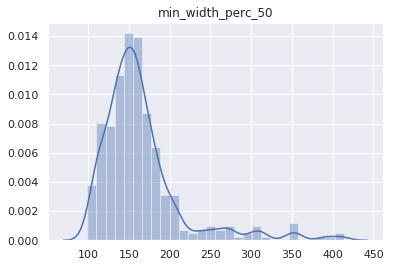

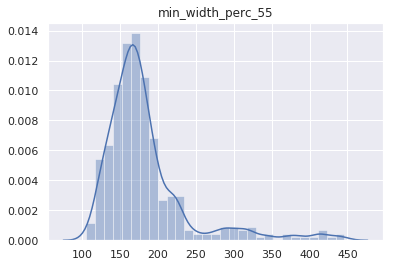

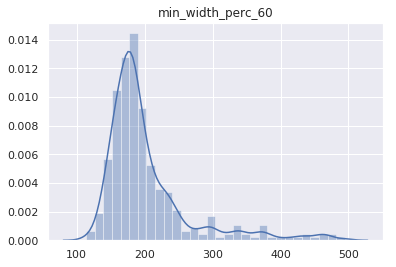

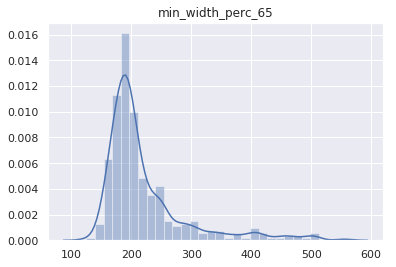

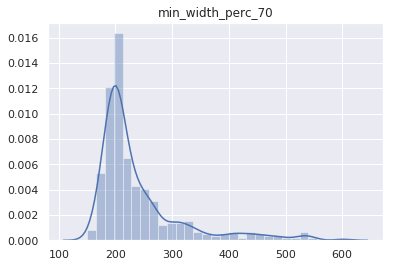

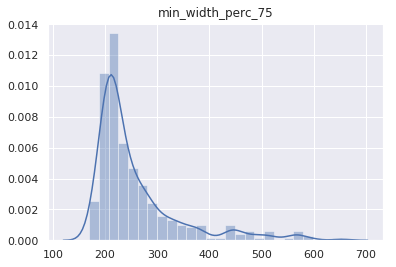

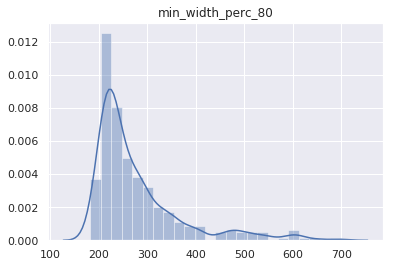

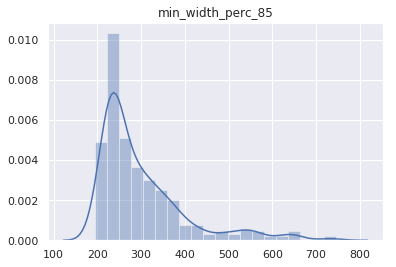

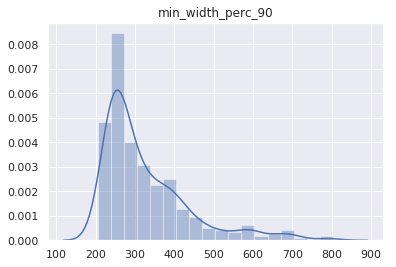

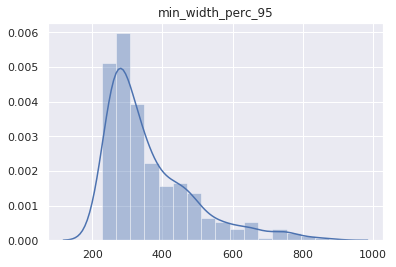

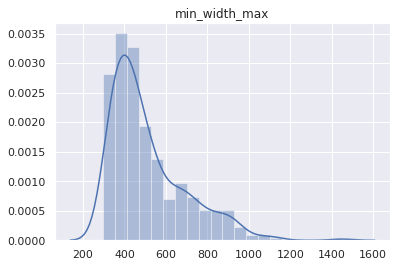

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plt.figure(i)
#     sns.countplot(x=col, data=df1)

for i,perc in enumerate(min_width_percentiles):
    plt.figure(i)
    plt.title(percentages_to_fetch[i])
    sns.distplot(perc)

In [74]:
#finding neurites to show
orphan_300 = (dendrite_accepted & "min_width_perc_80>295" & "min_width_perc_80<300").fetch("segment_id")[0]
orphan_450 = (dendrite_accepted & "min_width_perc_80>445" & "min_width_perc_80<455").fetch("segment_id")[0]
orphan_600 = (dendrite_accepted & "min_width_perc_80>595" & "min_width_perc_80<605").fetch("segment_id")[:5]
print(orphan_300)
print(orphan_450)
print(orphan_600)

648518346341366347
648518346341353607
[648518346341401733 648518346349495761]


In [75]:
#finding neurites to show
orphan_300 = (dendrite_accepted & "min_width_perc_95>295" & "min_width_perc_95<300").fetch("segment_id")[0:2]
orphan_450 = (dendrite_accepted & "min_width_perc_95>495" & "min_width_perc_95<505").fetch("segment_id")[0:2]
orphan_600 = (dendrite_accepted & "min_width_perc_95>595" & "min_width_perc_95<605").fetch("segment_id")[:5]
print(orphan_300)
print(orphan_450)
print(orphan_600)

[648518346341407034 648518346341413417]
[648518346341373284 648518346341396698]
[648518346341383775]


In [76]:
#finding neurites to show
orphan_300 = (dendrite_accepted & "min_width_perc_95>295" & "min_width_perc_80<300").fetch("segment_id")[0:2]
orphan_450 = (dendrite_accepted & "min_width_perc_90>445" & "min_width_perc_80<455").fetch("segment_id")[0:2]
orphan_600 = (dendrite_accepted & "min_width_perc_90>595" & "min_width_perc_80<605").fetch("segment_id")[:5]
print(orphan_300)
print(orphan_450)
print(orphan_600)

[648518346341352223 648518346341353186]
[648518346341353607 648518346341353883]
[648518346341396962 648518346341399130 648518346341401733
 648518346341401904 648518346342797258]


# Jake wants to do the stark difference of 0.1, 0.5 and 0.9 percentile parts

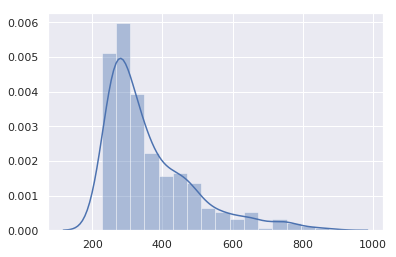

In [77]:
perc_95_data = dendrite_accepted.fetch("min_width_perc_95")
sns.distplot(perc_95_data)


In [78]:
#find the percentiles
percentile_numbers = [10,50,90]

percentile_list= []
for pn in percentile_numbers:
    percentile_list.append(np.percentile(perc_95_data,pn))
# percentile_list = [np.percentile(perc_95_data,10),
#                    np.percentile(perc_95_data,50),
#                   np.percentile(perc_95_data,90),
#                   ]

print(percentile_list)

[253.478, 321.75, 535.9755]


In [79]:
for i,perc in enumerate(percentile_list):
    print("Segments for Percentile: "+str(percentile_numbers[i]))
    orphan_segemnts = (dendrite_accepted & "min_width_perc_95>" + str(perc-5) & "min_width_perc_95<"+ str(perc+5)).fetch("segment_id")[0:5]
    print(orphan_segemnts)

Segments for Percentile: 10
[648518346341352006 648518346341356260 648518346341366977
 648518346341366999 648518346341367500]
Segments for Percentile: 50
[648518346341368864 648518346341396418 648518346341400003
 648518346341402112 648518346341405768]
Segments for Percentile: 90
[648518346341377161 648518346348190705]


# make Official looking graph for 95th percentile

In [80]:
dendrite_accepted.fetch("min_width_perc_95")

array([258.371, 300.18 , 335.249, 582.155, 494.533, 270.548, 254.333,
       473.654, 263.893, 328.8  , 237.08 , 373.338, 444.439, 263.361,
       454.041, 444.438, 260.669, 353.487, 242.531, 392.766, 290.36 ,
       332.222, 371.671, 366.044, 494.423, 255.095, 253.304, 476.601,
       253.984, 434.31 , 241.29 , 250.149, 421.621, 323.529, 425.743,
       484.24 , 276.57 , 343.557, 354.625, 337.352, 228.145, 497.897,
       300.579, 236.755, 266.864, 283.154, 433.207, 544.33 , 540.081,
       356.408, 258.43 , 351.757, 279.281, 339.375, 277.029, 875.717,
       329.879, 408.506, 242.121, 477.869, 365.337, 595.345, 285.402,
       329.862, 333.736, 582.716, 428.516, 575.972, 270.477, 274.072,
       489.677, 431.673, 512.66 , 280.798, 283.3  , 387.933, 556.416,
       282.89 , 340.56 , 350.907, 248.014, 490.349, 314.421, 425.972,
       326.498, 756.414, 415.784, 503.659, 739.094, 415.293, 247.071,
       257.55 , 409.795, 286.903, 477.46 , 270.587, 239.708, 331.026,
       765.815, 435.

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7f3cf1ab1048>>

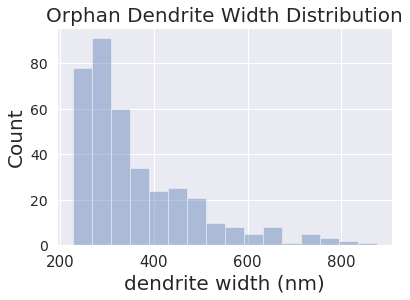

In [81]:
import seaborn as sns
sns.set()

ax =  sns.distplot(dendrite_accepted.fetch("min_width_perc_95"),kde=False)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel("Count",fontdict=dict(fontsize=20))
ax.set_xlabel("dendrite width (nm)",fontdict=dict(fontsize=20))
ax.set_title("Orphan Dendrite Width Distribution",fontdict=dict(fontsize=20))
ax.set

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6d8ccf60>>

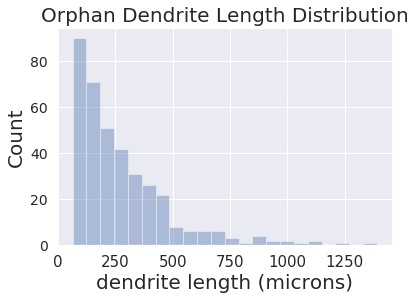

In [85]:
import seaborn as sns
sns.set()

ax =  sns.distplot(ta3p100.SignificantOrphanDendriteWidthLength.fetch("skeleton_length")/1000,kde=False)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel("Count",fontdict=dict(fontsize=20))
ax.set_xlabel("dendrite length (microns)",fontdict=dict(fontsize=20))
ax.set_title("Orphan Dendrite Length Distribution",fontdict=dict(fontsize=20))
ax.set

# Redoing the Plot in the same manner as Stelios

In [98]:
help(plt.xticks)

Help on function xticks in module matplotlib.pyplot:

xticks(ticks=None, labels=None, **kwargs)
    Get or set the current tick locations and labels of the x-axis.
    
    Call signatures::
    
        locs, labels = xticks()           # Get locations and labels
    
        xticks(ticks, [labels], **kwargs)  # Set locations and labels
    
    Parameters
    ----------
    ticks : array_like
        A list of positions at which ticks should be placed. You can pass an
        empty list to disable xticks.
    
    labels : array_like, optional
        A list of explicit labels to place at the given *locs*.
    
    **kwargs
        :class:`.Text` properties can be used to control the appearance of
        the labels.
    
    Returns
    -------
    locs
        An array of label locations.
    labels
        A list of `.Text` objects.
    
    Notes
    -----
    Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
    equivalent of calling `~.Axes.get_xticks` a

In [ ]:


fig, axs = plt.subplots(1, len(params), figsize=(n_axrow*scale,n_axcol*scale))

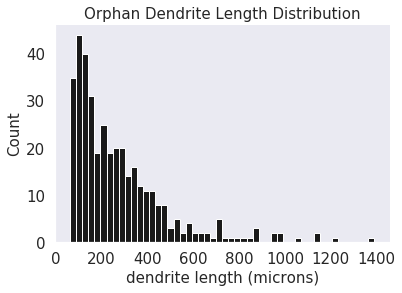

In [110]:
import matplotlib.pyplot as plt
plt.hist(ta3p100.SignificantOrphanDendriteWidthLength.fetch("skeleton_length")/1000,bins=50,color='k') 
plt.xlabel("dendrite length (microns)", fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Orphan Dendrite Length Distribution",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(b=None)
plt.
sns.despine()


In [ ]:
"""
import seaborn as sns
sns.set()

ax =  sns.distplot(dendrite_accepted.fetch("min_width_perc_95"),kde=False)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel("Count",fontdict=dict(fontsize=20))
ax.set_xlabel("dendrite width (nm)",fontdict=dict(fontsize=20))
ax.set_title("Orphan Dendrite Width Distribution",fontdict=dict(fontsize=20))
ax.set


"""

import matplotlib.pyplot as plt
plt.hist(ta3p100.SignificantOrphanDendriteWidthLength.fetch("width")/1000,bins=50,color='k') 
plt.xlabel("dendrite width (nm)", fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Orphan Dendrite Width Distribution",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(b=None)
sns.despine()


In [105]:
print(plt.__version__)

AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

NameError: name 'titles' is not defined

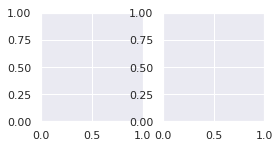

In [111]:
params = [ta3p100.SignificantOrphanDendriteWidthLength.fetch("width"),ta3p100.SignificantOrphanDendriteWidthLength.fetch("skeleton_length")/1000]
scale=2
n_axrow = len(params)
n_axcol = 1
fig, axs = plt.subplots(1, len(params), figsize=(n_axrow*scale,n_axcol*scale))
for ax, param, title in zip(axs, params, titles):
    ax.hist(param, bins=50, color='k')
    ax.set_xlabel(title, fontsize=15)
axs[0].set_ylabel('Number of Axons', fontsize=15)
fig.suptitle('Intrinsic Orphan Axon Properties', fontsize=25, y=1.02)
# sns.despine()
fig.set_dpi(150)

In [ ]:
"""
************ CODE THAT FINDS THE 
"""

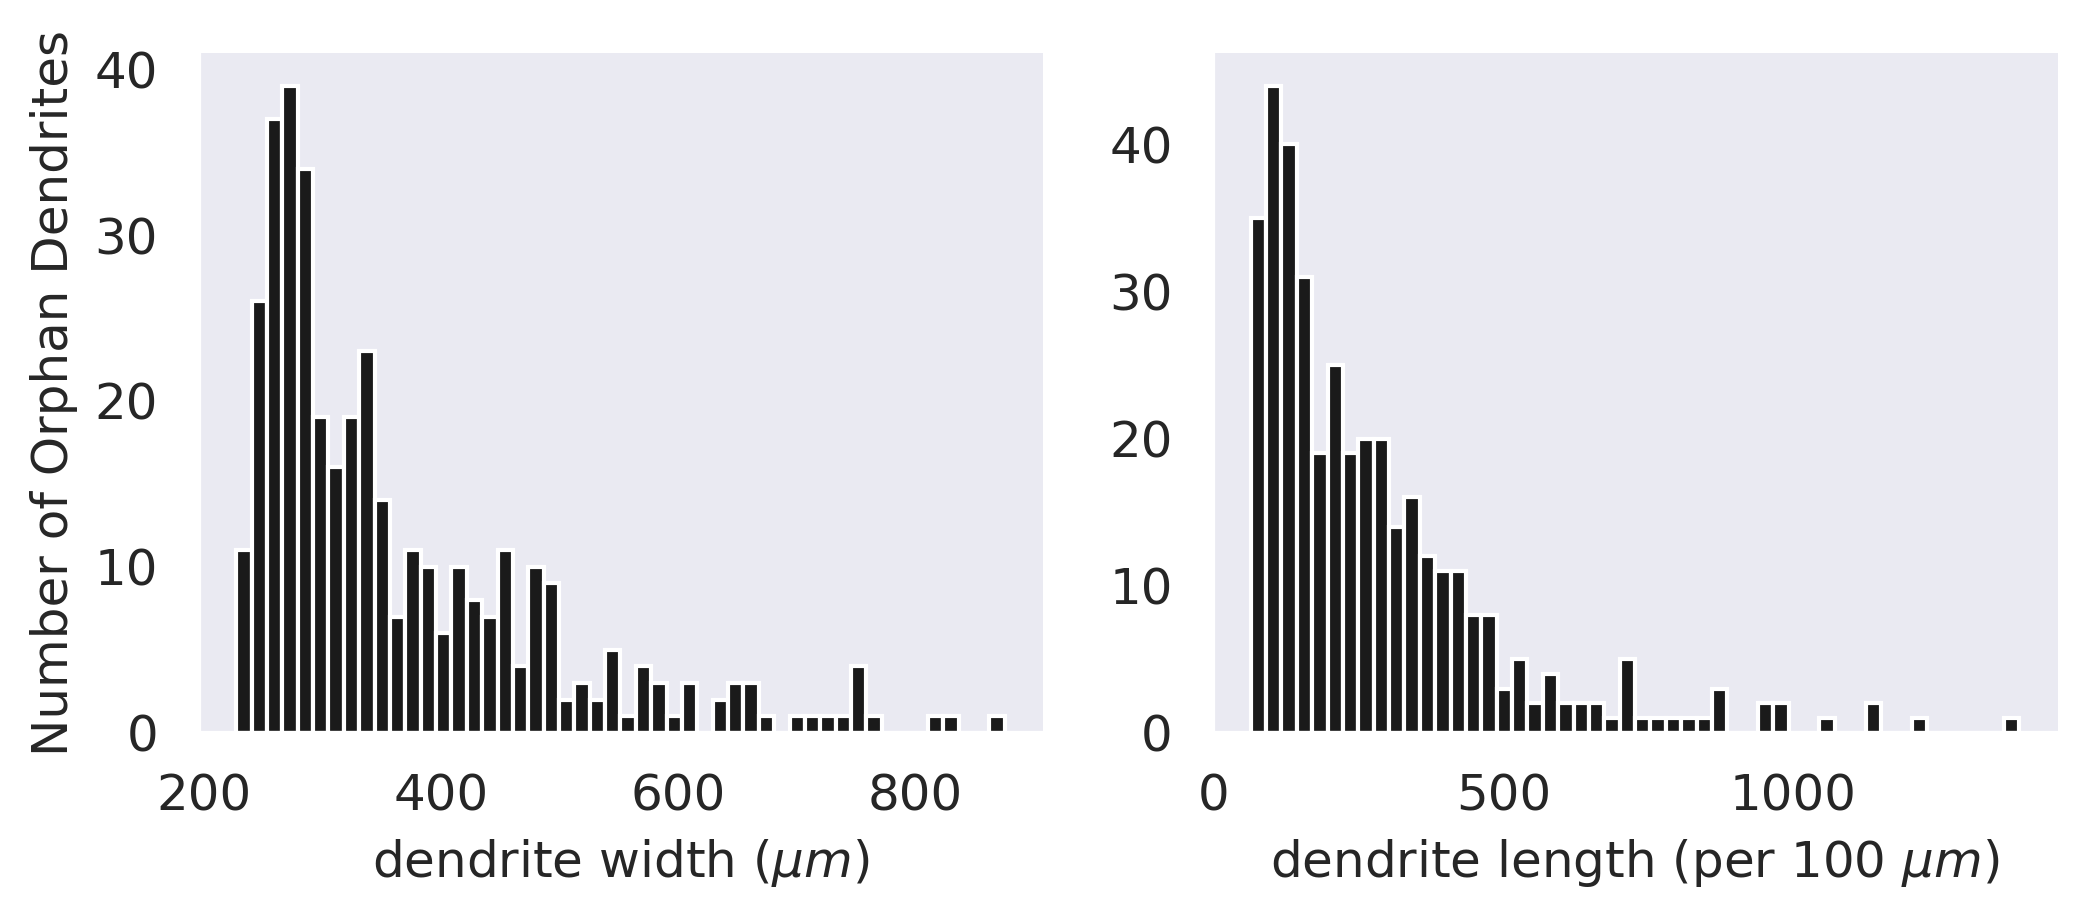

In [121]:
widths = ta3p100.SignificantOrphanDendriteWidthLength.fetch("width")

lengths = ta3p100.SignificantOrphanDendriteWidthLength.fetch("skeleton_length")/1000

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(widths, bins=50, color='k')
ax2.hist(lengths, bins=50, color='k')

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax1.set_xlabel('dendrite width ($\mu m$)', fontsize=12)
ax2.set_xlabel('dendrite length (per 100 $\mu m$)', fontsize=12)

ax1.set_ylabel('Number of Orphan Dendrites', fontsize=12)
fig.set_size_inches(8,3)
fig.set_dpi(300)

#plt.grid(False)
ax1.grid(b=None)
ax2.grid(b=None)
sns.despine()

In [119]:
help(ax.set_ylabel)

fontdict=dict(fontsize=13)

Help on method set_ylabel in module matplotlib.axes._axes:

set_ylabel(ylabel, fontdict=None, labelpad=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the label for the y-axis.
    
    Parameters
    ----------
    ylabel : str
        The label text.
    
    labelpad : scalar, optional, default: None
        Spacing in points between the label and the y-axis.
    
    Other Parameters
    ----------------
    **kwargs : `.Text` properties
        `.Text` properties control the appearance of the label.
    
    See also
    --------
    text : for information on how override and the optional args work



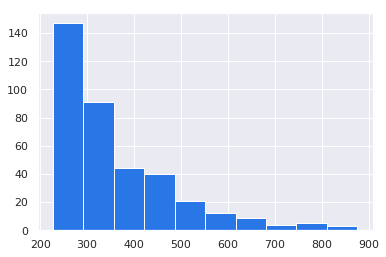

In [104]:
perc_95_data = dendrite_accepted.fetch("min_width_perc_95")

import matplotlib.pyplot as plt


plt.hist(perc_95_data,color = '#2977E7',label='shaft')
# plt.plot([0,len(x)],[0.5,0.5],color="#322FE7",label='shaft_threshold')
# plt.plot(range(0,len(y)),y,color="#E7803C",label='spine head')
# plt.plot([0,len(x)],[0.6,0.6],color="#E73035",label='spine_head_threshold')

# plt.ylabel('proportion',fontsize=18)
# plt.xlabel('neurite index (spine head sorted)',fontsize=18)
# plt.legend(loc=3)


# plt.tick_params(axis='x', which='major', labelsize=13)
# plt.tick_params(axis='y', which='major', labelsize=18)

plt.show()


In [138]:
dendrite_labels = ["Apical","Basal","Oblique","Dendrite"]


#dj.U("segment_id").aggr(ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels]
#ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500"
exhitatory = dj.U("segment_id").aggr(ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")





Decimal('619')

In [146]:
dendrite_labels = ["Apical","Basal","Oblique","Dendrite"]


#dj.U("segment_id").aggr(ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels]
#ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500"
exhitatory = dj.U("segment_id").aggr(ta3p100.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

orphan = dj.U("segment_id").aggr(ta3p100.CompartmentOrphan.ComponentOrphan() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

restriction_threshold = 15000
dendrite_restriction = ((exhitatory & "dendrite_vertex_count>" + str(restriction_threshold)).proj() + 
                            (orphan & "dendrite_vertex_count>" + str(restriction_threshold)).proj()) - ta3p100.SegmentExclude.proj()

#dendrite_restriction



# FINDING THE NUMBERS FOR THE FINAL REPORT

In [ ]:
"""
Orphaned dendritic segments ranged in total length from XX um to XX um,
 Maximum (95th percentile) dendritic width varied from XX um to XXum
 Synapse density ranged from XX synapses/100 um to XX, with densities 
[higher/lower] on L5 trunks compared to the small and medium-diameter dendrites.
"""


In [151]:
#searching for the widths
fat_orphan_dendrites = (ta3p100.CompartmentOrphan.ComponentOrphan() & "compartment_type='Dendrite'" & 
        (ta3p100.SignificantOrphanDendriteWidthLength() & "width > 600"))

In [161]:
#Orphaned dendritic segments ranged in total length from XX um to XX um,
#Maximum (95th percentile) dendritic width varied from XX um to XXum
skeleton_length = ta3p100.SignificantOrphanDendriteWidthLength.fetch("skeleton_length")
print("min(skeleton_length) = " + str(min(skeleton_length/1000)))
print("max(skeleton_length) = " + str(max(skeleton_length/1000)))

min(skeleton_length) = 63.3243
max(skeleton_length) = 1389.92


In [156]:
#Maximum (95th percentile) dendritic width varied from XX um to XXum
width_data = ta3p100.SignificantOrphanDendriteWidthLength.fetch("width")
print("min(width_data) = " + str(min(width_data)))
print("max(width_data) = " + str(max(width_data)))

min(width_data) = 227.154
max(width_data) = 875.717


In [3]:
#table that aggregates number of synapses over postsyn
postsyn_n_synapses = dj.U("postsyn").aggr(ta3p100.Synapse,n_synapses="count(*)")
postsyn_data = postsyn_n_synapses.fetch("postsyn","n_synapses")

In [9]:
postsyn = postsyn_data[0]
n_synapses = postsyn_data[1]

n_synapses_lookup = dict()
for i,p in enumerate(postsyn):
    n_synapses_lookup[str(p)] = n_synapses[i]


In [48]:
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
Synapse density ranged from XX synapses/100 um to XX, with densities 
[higher/lower] on L5 trunks compared to the small and medium-diameter dendrites.
"""
l5_width_threshold = 700

# l5_apicals = (ta3p100.SignificantOrphanDendriteWidthLength & "width>="+str(l5_width_threshold) )
# others = (ta3p100.SignificantOrphanDendriteWidthLength & "width<"+str(l5_width_threshold) )

#get widths and synaptic density and see if there is difference
orphan_data = ta3p100.SignificantOrphanDendriteWidthLength.fetch("segment_id","width","skeleton_length")
segment_id = orphan_data[0]
orphan_width = orphan_data[1]
skeleton_length = orphan_data[2]

orphan_synapse_density = []
for i,seg_id in tqdm(enumerate(segment_id)):
    key = dict(postsyn=seg_id)
    #get the number of synapses
    n_syn = n_synapses_lookup[str(seg_id)]
    
    #get the length of the dendrite
    length_nm = skeleton_length[i]

    #calculate the synapse density
    density = n_syn/(length_nm*1000*100)
    
    orphan_synapse_density.append(density*1000000000)
    
print(min(orphan_synapse_density))
print(max(orphan_synapse_density))




# l5_synapse_density = []
# other_synapse_density = []

# for l5 in l5_apicals:
#     key = dict(postsyn=l5)
#     #get the number of synapses
#     n_syn = (postsyn_n_synapses & key).fetch1("n_synapses")
    
#     #get the length of the dendrite
#     length_nm = (ta3p100.SignificantOrphanDendriteWidthLength & "segment_id=" + str(l5)).fetch1("skeleton_length")
    
#     #calculate the synapse density
#     density = n_syn/(length_nm*1000*100)
    
#     l5_synapse_density.append(density)

# for l5 in others:
#     key = dict(postsyn=l5)
#     #get the number of synapses
#     n_syn = (postsyn_n_synapses & key).fetch1("n_synapses")
    
#     #get the length of the dendrite
#     length_nm = (ta3p100.SignificantOrphanDendriteWidthLength & "segment_id=" + str(l5)).fetch1("skeleton_length")
    
#     #calculate the synapse density
#     density = n_syn/(length_nm*1000*100)
    
#     l5_synapse_density.append(density)
    
    


376it [00:00, 81480.67it/s]

2.7050003864286265
27.195629614609302


In [49]:
print(min(orphan_synapse_density))
print(max(orphan_synapse_density))

2.7050003864286265
27.195629614609302


<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7f3c6ec01d30>>

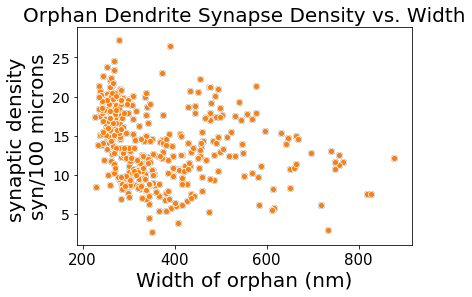

In [50]:
#plot the distribution
plt.scatter(x = orphan_width,y = orphan_synapse_density)

ax = sns.scatterplot(orphan_width,orphan_synapse_density)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel("synaptic density \nsyn/100 microns",fontdict=dict(fontsize=20))
ax.set_xlabel("Width of orphan (nm)",fontdict=dict(fontsize=20))
ax.set_title("Orphan Dendrite Synapse Density vs. Width",fontdict=dict(fontsize=20))
ax.set
# plt.xlabel("width of orphan (nm)")
# plt.show()
    

In [31]:
l5_width_threshold = 700


l5_orphan_data = (ta3p100.SignificantOrphanDendriteWidthLength & 
               "width>="+str(l5_width_threshold)).fetch("segment_id","width","skeleton_length")
l5_segment_id = l5_orphan_data[0]
l5_orphan_width = l5_orphan_data[1]
l5_skeleton_length = l5_orphan_data[2]

orphan_data = (ta3p100.SignificantOrphanDendriteWidthLength & 
               "width<"+str(l5_width_threshold)).fetch("segment_id","width","skeleton_length")
segment_id = orphan_data[0]
orphan_width = orphan_data[1]
skeleton_length = orphan_data[2]


l5_synapse_density = []
other_synapse_density = []

for i,seg_id in tqdm(enumerate(l5_segment_id)):
    key = dict(postsyn=seg_id)
    #get the number of synapses
    n_syn = n_synapses_lookup[str(seg_id)]
    
    #get the length of the dendrite
    length_nm = l5_skeleton_length[i]

    #calculate the synapse density
    density = n_syn/(length_nm*1000*100)
    
    l5_synapse_density.append(density*1000000000)
    
for i,seg_id in tqdm(enumerate(segment_id)):
    key = dict(postsyn=seg_id)
    #get the number of synapses
    n_syn = n_synapses_lookup[str(seg_id)]
    
    #get the length of the dendrite
    length_nm = skeleton_length[i]

    #calculate the synapse density
    density = n_syn/(length_nm*1000*100)
    
    other_synapse_density.append(density*1000000000)

11it [00:00, 36733.55it/s]
365it [00:00, 137871.12it/s]


In [38]:
import math
print("L5 Synapse Density Statistics (Width >=700 nm )")
print("count = " + str(len(l5_synapse_density)))
print("max synapse density = " + str(max(l5_synapse_density)))
print("mean synapse density = " + str(np.mean(l5_synapse_density)))
print("median synapse density = " + str(np.median(l5_synapse_density)))
print("min synapse density = " + str(min(l5_synapse_density)))
print("\n\n")
print("Non L5 Synapse Density Statistics (Width <700 nm )")
print("count = " + str(len(other_synapse_density)))
print("max synapse density = " + str(max(other_synapse_density)))
print("mean synapse density = " + str(np.mean(other_synapse_density)))
print("median synapse density = " + str(np.median(other_synapse_density)))
print("min synapse density = " + str(min(other_synapse_density)))

L5 Synapse Density Statistics (Width >=700 nm )
count = 11
max synapse density = 13.03573909993846
mean synapse density = 9.748014260787636
median synapse density = 11.226083561108942
min synapse density = 3.0004279557768503



Non L5 Synapse Density Statistics (Width <700 nm )
count = 365
max synapse density = 27.195629614609302
mean synapse density = 14.1513492112238
median synapse density = 14.281828073993472
min synapse density = 2.7050003864286265


In [174]:
l5_synapse_density
key = dict(postsyn=648518346345770568)
#get the number of synapses
n_syn = (postsyn_n_synapses & key).fetch1("n_synapses")

#get the length of the dendrite
length_nm = (ta3p100.SignificantOrphanDendriteWidthLength & "segment_id=" + str(648518346345770568)).fetch1("skeleton_length")

#calculate the synapse density
density = n_syn/(length_nm*1000*100)

l5_synapse_density.append(density)

NameError: name 'l5_synapse_density' is not defined

In [170]:
(ta3p100.Synapse() & "postsyn=648518346341379951") - ta3p100.SynapseExcludeFinal

segmentation segmentation id,synapse_id synapse index within the segmentation,presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),presyn_x (EM voxels),presyn_y (EM voxels),presyn_z (EM voxels),postsyn_x (EM voxels),postsyn_y (EM voxels),postsyn_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,size (EM voxels)
1,9991,648518346344423010,648518346341379951,52214,54678,1610,52230,54666,1612,52154,54674,1612,52154,54666,1612,52230,54674,1612,62
1,23575,648518346341375956,648518346341379951,53686,63942,1881,53680,63946,1882,53696,63906,1880,53680,63906,1880,53696,63946,1882,63
1,57942,648518346345500969,648518346341379951,51738,55270,1630,51694,55268,1628,51780,55284,1628,51694,55268,1628,51780,55284,1628,66
1,117101,648518346344509595,648518346341379951,53190,59176,1694,53236,59186,1691,53132,59132,1691,53132,59132,1691,53236,59186,1691,70
1,125256,648518346345757981,648518346341379951,54024,63392,1806,54066,63406,1805,53972,63434,1805,53972,63406,1805,54066,63434,1805,71
1,249427,648518346341379336,648518346341379951,55277,72729,2091,55278,72694,2087,55206,72714,2088,55206,72694,2087,55278,72714,2088,530
1,271635,648518346343456494,648518346341379951,55236,73556,2110,55256,73492,2112,55150,73506,2110,55150,73492,2110,55256,73506,2112,83
1,289352,648518346341373789,648518346341379951,52500,54900,1468,52512,54936,1467,52480,54876,1468,52480,54876,1467,52512,54936,1468,85
1,310048,648518346344513199,648518346341379951,52324,58733,1629,52278,58786,1630,52310,58712,1631,52278,58712,1630,52310,58786,1631,316
1,371576,648518346341387812,648518346341379951,54670,73064,2012,54640,73048,2010,54698,73074,2009,54640,73048,2009,54698,73074,2010,92


In [44]:
sizes = (ta3p100.CompartmentFinal.ComponentFinal & "compartment_type='Apical'").fetch("n_vertex_indices")
max(sizes)



311106